EDA
모델 폴더 구조
Model
- raw_data
  - Training
    -label
        -K-015710-016262-027653-031885_json (folder)
            -K-015710 (folder) 각 약제 코드별 annotation 데이터
                - K-016235-025367-027653-029667_0_2_0_2_70_000_200_json
                - K-016235-025367-027653-029667_0_2_0_2_75_000_200_json
                - K-016235-025367-027653-029667_0_2_0_2_90_000_200_json
            -K-016262 (folder)
                -이하 동일
    -raw
        -K-001900-010224-016551-031705_0_2_0_2_70_000_200 (각도별 여러장)
        -K-001900-016548-018110-029345_0_2_0_2_70_000_200 (각도별 여러장)


        -이하 동일
  - Validation
    -label (위와 동일)
    -raw
        -K-016235-027733-029667-031885(folder)
            --촬영 각도별(70,75,90) 이미지 및 index 이미지 (총 4장) data_type : png

EDA 과정
1. JSON 파일 개수 확인 및 JSON+PNG 페어쌍 확인
2. annotaion bbox중 bbox의 길이가 4가 아닌 bad_bbox 확인 및 삭제
3. 과도하게 겹치는 iou_matrix 확인
4. bbox 크기 분포 확인 및 과도하게 크거나 작은 bbox 삭제
5. bbox가 이미지 밖으로 나간 경우
6. annotation이 없는 이미지 존재 여부
7. 클래스 분포 확인 및 Validation에만 존재하는 클래스 삭제 -> Validation은 추후 Test로 용도 변경
8. JSON ↔ PNG 쌍 존재 여부 재확인 및 존재하지 않는 Pair 삭제



In [1]:
#0 원본 데이터 압축 해제 및 labe, raw 디렉토리 생성
import os
import shutil
import zipfile

# ========= 설정 =========
PROJECT_ROOT = os.getcwd()
RAW_DATA_ROOT = os.path.join(PROJECT_ROOT, "raw_data")

TRAIN_DIR = os.path.join(RAW_DATA_ROOT, "Training")
VAL_DIR   = os.path.join(RAW_DATA_ROOT, "Validation")

TRAIN_ZIP = os.path.join(TRAIN_DIR, "Training_data.zip")
VAL_LABEL_ZIP = os.path.join(VAL_DIR, "VL_1_조합.zip")
VAL_RAW_ZIP   = os.path.join(VAL_DIR, "VS_1_조합.zip")


# ========= 유틸 =========
def unzip(zip_path, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    with zipfile.ZipFile(zip_path, "r") as zf:
        zf.extractall(dst_dir)

def rm_dir(path):
    if os.path.isdir(path):
        shutil.rmtree(path)

def mv(src, dst):
    if os.path.exists(dst):
        rm_dir(dst) if os.path.isdir(dst) else os.remove(dst)
    os.rename(src, dst)

def flatten_if_single_subdir(dst_dir):
    # 압축 풀었더니 dst_dir 아래에 폴더 1개만 생기는 케이스 정리
    items = [p for p in os.listdir(dst_dir) if p not in [".DS_Store"]]
    if len(items) == 1:
        only = os.path.join(dst_dir, items[0])
        if os.path.isdir(only):
            for name in os.listdir(only):
                shutil.move(os.path.join(only, name), os.path.join(dst_dir, name))
            rm_dir(only)


# ========= 1) Training_data.zip 처리 =========
def setup_training():
    # 0) 압축 해제 위치: raw_data/Training/
    unzip(TRAIN_ZIP, TRAIN_DIR)
    flatten_if_single_subdir(TRAIN_DIR)

    # 1) test_images 폴더 완전 삭제
    rm_dir(os.path.join(TRAIN_DIR, "test_images"))

    # 2) train_annotations -> label
    src_anno = os.path.join(TRAIN_DIR, "train_annotations")
    dst_label = os.path.join(TRAIN_DIR, "label")
    if os.path.isdir(src_anno):
        mv(src_anno, dst_label)

    # 3) train_images(or train_image) -> raw
    src_imgs_a = os.path.join(TRAIN_DIR, "train_images")
    dst_raw = os.path.join(TRAIN_DIR, "raw")

    if os.path.isdir(src_imgs_a):
        mv(src_imgs_a, dst_raw)


    print("[OK] Training setup done")


# ========= 2) Validation zip 2개 처리 =========
def setup_validation():
    # 1) VL_1_조합.zip -> Validation/label
    label_dir = os.path.join(VAL_DIR, "label")
    rm_dir(label_dir)
    unzip(VAL_LABEL_ZIP, label_dir)
    flatten_if_single_subdir(label_dir)

    # 2) VS_1_조합.zip -> Validation/raw
    raw_dir = os.path.join(VAL_DIR, "raw")
    rm_dir(raw_dir)
    unzip(VAL_RAW_ZIP, raw_dir)
    flatten_if_single_subdir(raw_dir)

    print("[OK] Validation setup done")


if __name__ == "__main__":
    setup_training()
    setup_validation()

[OK] Training setup done
[OK] Validation setup done


In [2]:
#1. JSON ↔ PNG 존재 여부 확인
import os
import json
import numpy as np

# =========================
# JSON 파일 검색 및 읽기
def search_json_files(directory):
    json_files = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith('.json'):
                json_files.append(os.path.join(root, file))
    return json_files

def read_json(json_path):
    with open(json_path, 'r', encoding="utf-8") as f:
        return json.load(f)


# =========================
# 디렉토리 설정 (단일 변수 체계)
PROJECT_ROOT = os.getcwd()
RAW_DATA_ROOT = os.path.join(PROJECT_ROOT, "raw_data")

TRAIN_LABEL_DIR = os.path.join(RAW_DATA_ROOT, "Training", "label")
TRAIN_RAW_DIR   = os.path.join(RAW_DATA_ROOT, "Training", "raw")

VAL_LABEL_DIR = os.path.join(RAW_DATA_ROOT, "Validation", "label")
VAL_RAW_DIR   = os.path.join(RAW_DATA_ROOT, "Validation", "raw")


# =========================
# JSON 경로 수집
train_json_paths = search_json_files(TRAIN_LABEL_DIR)
val_json_paths   = search_json_files(VAL_LABEL_DIR)

all_json_paths = train_json_paths + val_json_paths

# =========================
# JSON 개수 확인
def count_json_files(json_paths, name):
    print(f"{name} JSON 개수: {len(json_paths)}")
    return len(json_paths)


# =========================
# JSON ↔ PNG 존재 여부 확인
def check_json_png_match(json_paths, raw_root_dir, max_print=20):
    missing = []
    checked = 0

    for jp in json_paths:
        data = read_json(jp)

        for img in data.get("images", []):
            fname = img.get("file_name")
            if not fname:
                continue

            found = False
            for root, _, files in os.walk(raw_root_dir):
                if fname in files:
                    found = True
                    break

            if not found:
                missing.append(fname)
                if len(missing) <= max_print:
                    print(f"missing png: {fname}")

            checked += 1

    print(f"\n총 이미지 entries: {checked}")
    print(f"png 누락: {len(missing)}")
    return missing


# =========================
count_json_files(train_json_paths, "Train")
count_json_files(val_json_paths, "Validation") 

missing_train = check_json_png_match(train_json_paths, TRAIN_RAW_DIR)
missing_val   = check_json_png_match(val_json_paths, VAL_RAW_DIR)

Train JSON 개수: 4526
Validation JSON 개수: 5520

총 이미지 entries: 4526
png 누락: 0

총 이미지 entries: 5520
png 누락: 0


In [3]:
#2. 겹치는 박스 찾기 및 해당 json+png쌍 삭제 (IoU≥0.5, 다른 클래스만)
def find_overlapping_images(
    json_paths,
    iou_thr=0.5,
    only_diff_class=True,
    max_print_per_image=5,
    save_txt_path=None,
):
    per_image = {}

    def xywh_to_xyxy(x, y, w, h):
        return [x, y, x + w, y + h]

    for json_path in json_paths:
        data = read_json(json_path)

        img_mapping = {}
        for img in data.get("images", []):
            # id, file_name, width, height만 사용
            img_mapping[img["id"]] = (img["file_name"], img["width"], img["height"])

        for ann in data.get("annotations", []):
            if ann.get("iscrowd", 0) == 1:
                continue

            bbox = ann.get("bbox", None)
            if not bbox or len(bbox) != 4:
                continue  

            image_id = ann.get("image_id", None)
            cat_id = ann.get("category_id", None)
            if image_id is None or cat_id is None:
                continue

            if image_id not in img_mapping:
                continue

            file_name, w_img, h_img = img_mapping[image_id]

            if image_id not in per_image:
                per_image[image_id] = {
                    "file_name": file_name,
                    "img_w": w_img,
                    "img_h": h_img,
                    "anns": [],
                }

            x, y, w, h = bbox
            per_image[image_id]["anns"].append(
                {
                    "ann_id": ann.get("id", None),
                    "cat": cat_id,
                    "xyxy": xywh_to_xyxy(x, y, w, h),
                }
            )

    def iou_matrix_xyxy(boxes):
        b = np.array(boxes, dtype=np.float32)
        if b.shape[0] == 0:
            return np.zeros((0, 0), dtype=np.float32)

        x1, y1, x2, y2 = b[:, 0], b[:, 1], b[:, 2], b[:, 3]
        area = np.clip(x2 - x1, 0, None) * np.clip(y2 - y1, 0, None)

        x1m = np.maximum(x1[:, None], x1[None, :])
        y1m = np.maximum(y1[:, None], y1[None, :])
        x2m = np.minimum(x2[:, None], x2[None, :])
        y2m = np.minimum(y2[:, None], y2[None, :])

        inter_w = np.clip(x2m - x1m, 0, None)
        inter_h = np.clip(y2m - y1m, 0, None)
        inter = inter_w * inter_h
        union = area[:, None] + area[None, :] - inter
        union = np.where(union <= 0, 1e-9, union)
        return inter / union

    bad_image_ids = set()
    lines = []
    total_pairs = 0

    for image_id, meta in per_image.items():
        anns = meta["anns"]
        if len(anns) < 2:
            continue

        boxes = [a["xyxy"] for a in anns]
        cats = [a["cat"] for a in anns]
        ious = iou_matrix_xyxy(boxes)

        found_here = 0
        for i in range(len(anns)):
            for j in range(i + 1, len(anns)):
                iou = float(ious[i, j])
                if iou >= iou_thr and ((not only_diff_class) or (cats[i] != cats[j])):
                    if found_here == 0:
                        header = (
                            f"[image_id={image_id}] file={meta['file_name']} "
                            f"(w={meta['img_w']}, h={meta['img_h']})"
                        )
                        print(header)
                        lines.append(header)

                    found_here += 1
                    total_pairs += 1
                    msg = (
                        f"  - ann#{anns[i]['ann_id']} (cat={cats[i]}) vs "
                        f"ann#{anns[j]['ann_id']} (cat={cats[j]}): IoU={iou:.3f}"
                    )
                    print(msg)
                    lines.append(msg)

                    if found_here >= max_print_per_image:
                        more = f"  ... and more ({len(anns)} boxes total)"
                        print(more)
                        lines.append(more)
                        break
            if found_here >= max_print_per_image:
                break

        if found_here > 0:
            bad_image_ids.add(image_id)

    summary = (
        f"\n요약: 문제 이미지 {len(bad_image_ids)}개, "
        f"조건(IoU≥{iou_thr}, only_diff_class={only_diff_class})에 걸린 쌍 {total_pairs}개"
    )
    print(summary)
    lines.append(summary)

    if save_txt_path:
        os.makedirs(os.path.dirname(save_txt_path), exist_ok=True)
        with open(save_txt_path, "w", encoding="utf-8") as f:
            f.write("\n".join(lines))
        print(f"로그 저장 → {save_txt_path}")

    return bad_image_ids

def delete_overlapping_pairs(bad_image_ids, json_paths, raw_root_dir):
    import os

    # image_id -> file_name 매핑 수집
    id_to_file = {}
    for jp in json_paths:
        data = read_json(jp)
        for img in data.get("images", []):
            if img.get("id") in bad_image_ids:
                id_to_file[img["id"]] = img.get("file_name")

    # png 삭제
    for fname in id_to_file.values():
        for root, _, files in os.walk(raw_root_dir):
            if fname in files:
                os.remove(os.path.join(root, fname))
                break

    # json 삭제 (해당 image_id 포함된 json)
    for jp in json_paths:
        data = read_json(jp)
        img_ids = {img.get("id") for img in data.get("images", [])}
        if img_ids & bad_image_ids:
            os.remove(jp)

bad_train = find_overlapping_images(train_json_paths)
bad_val   = find_overlapping_images(val_json_paths)

delete_overlapping_pairs(bad_train, train_json_paths, TRAIN_RAW_DIR)
delete_overlapping_pairs(bad_val,   val_json_paths,   VAL_RAW_DIR)



[image_id=1228] file=K-001900-016548-019607-033009_0_2_0_2_70_000_200.png (w=976, h=1280)
  - ann#4683 (cat=16547) vs ann#4691 (cat=33008): IoU=1.000
[image_id=754] file=K-003351-003832-029667_0_2_0_2_90_000_200.png (w=976, h=1280)
  - ann#2862 (cat=3831) vs ann#2870 (cat=29666): IoU=1.000
[image_id=243] file=K-003351-018147-020238_0_2_0_2_90_000_200.png (w=976, h=1280)
  - ann#910 (cat=3350) vs ann#916 (cat=20237): IoU=1.000
[image_id=907] file=K-003351-020238-031863_0_2_0_2_70_000_200.png (w=976, h=1280)
  - ann#3444 (cat=3350) vs ann#3441 (cat=20237): IoU=1.000
[image_id=208] file=K-003351-029667-031863_0_2_0_2_70_000_200.png (w=976, h=1280)
  - ann#791 (cat=3350) vs ann#788 (cat=31862): IoU=1.000

요약: 문제 이미지 5개, 조건(IoU≥0.5, only_diff_class=True)에 걸린 쌍 5개

요약: 문제 이미지 0개, 조건(IoU≥0.5, only_diff_class=True)에 걸린 쌍 0개


In [4]:
#3. bbox 길이 4개 아닌 annotation 찾기 및 해당 json+png쌍 삭제
import os
from datetime import datetime

def find_bad_bbox_jsons(json_paths, save_txt_path="bad_bbox_jsons.txt", max_print=50):
    bad_records = []
    total_bad_anns = 0

    for jp in json_paths:
        if not os.path.exists(jp):
            continue

        data = read_json(jp)
        for ann in data.get("annotations", []):
            bbox = ann.get("bbox", None)
            if bbox is None:
                continue
            if isinstance(bbox, (list, tuple)) and len(bbox) != 4:
                total_bad_anns += 1
                bad_records.append(
                    f"{jp} | image_id={ann.get('image_id')} ann_id={ann.get('id')} "
                    f"category_id={ann.get('category_id')} bbox_len={len(bbox)} bbox={bbox}"
                )

    header = [
        f"총 JSON: {len(json_paths)}",
        f"bbox 길이!=4 인 annotation 수: {total_bad_anns}",
        f"기록 라인 수: {len(bad_records)}",
        "",
    ]

    os.makedirs(os.path.dirname(save_txt_path) or ".", exist_ok=True)
    with open(save_txt_path, "w", encoding="utf-8") as f:
        f.write("\n".join(header))
        f.write("\n".join(bad_records))  

    # 콘솔 출력만 제한
    if max_print is not None:
        for line in bad_records[:max_print]:
            print(line)
        if len(bad_records) > max_print:
            print(f"... truncated print: {len(bad_records) - max_print} more lines")

    print(f"저장 완료 → {save_txt_path}")
    print(f"bbox 길이!=4 인 annotation 수: {total_bad_anns}")

    return bad_records


def delete_bad_bbox_pairs_from_txt(txt_path, raw_root_dir, log_dir="logs"):
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir,
        f"deleted_bad_bbox_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    deleted_lines = []
    deleted_json = 0
    deleted_png = 0

    with open(txt_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    for line in lines:
        if ".json" not in line or "|" not in line:
            continue

        json_path = line.split("|")[0].strip()
        if not os.path.exists(json_path):
            continue

        data = read_json(json_path)

        # PNG 삭제
        for img in data.get("images", []):
            fname = img.get("file_name")
            if not fname:
                continue
            for root, _, files in os.walk(raw_root_dir):
                if fname in files:
                    png_path = os.path.join(root, fname)
                    os.remove(png_path)
                    deleted_lines.append(f"PNG DELETE: {png_path}")
                    deleted_png += 1
                    break

        # JSON 삭제
        os.remove(json_path)
        deleted_lines.append(f"JSON DELETE: {json_path}")
        deleted_json += 1

    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n")
        f.write(f"삭제 PNG: {deleted_png}\n\n")
        f.write("\n".join(deleted_lines))

    print(f"삭제 완료 → JSON:{deleted_json}, PNG:{deleted_png}")
    print(f"삭제 로그 저장 → {log_path}")

find_bad_bbox_jsons(train_json_paths, "bad_bbox_train.txt")
find_bad_bbox_jsons(val_json_paths,   "bad_bbox_val.txt")

delete_bad_bbox_pairs_from_txt("bad_bbox_train.txt", TRAIN_RAW_DIR)
delete_bad_bbox_pairs_from_txt("bad_bbox_val.txt",   VAL_RAW_DIR)


저장 완료 → bad_bbox_train.txt
bbox 길이!=4 인 annotation 수: 0
c:\Users\USER\Desktop\Project1\Model\raw_data\Validation\label\K-016262-027653-030308-038723_json\K-016262\K-016262-027653-030308-038723_0_2_0_2_90_000_200.json | image_id=1 ann_id=1 category_id=1 bbox_len=0 bbox=[]
c:\Users\USER\Desktop\Project1\Model\raw_data\Validation\label\K-016262-027653-030308-038723_json\K-027653\K-016262-027653-030308-038723_0_2_0_2_90_000_200.json | image_id=1 ann_id=1 category_id=1 bbox_len=0 bbox=[]
c:\Users\USER\Desktop\Project1\Model\raw_data\Validation\label\K-016262-027653-030308-038723_json\K-030308\K-016262-027653-030308-038723_0_2_0_2_90_000_200.json | image_id=1 ann_id=1 category_id=1 bbox_len=0 bbox=[]
c:\Users\USER\Desktop\Project1\Model\raw_data\Validation\label\K-016262-027653-030308-038723_json\K-038723\K-016262-027653-030308-038723_0_2_0_2_90_000_200.json | image_id=1 ann_id=1 category_id=1 bbox_len=0 bbox=[]
c:\Users\USER\Desktop\Project1\Model\raw_data\Validation\label\K-016548-029345-0


=== Train ===
bbox 개수: 4512
area mean: 0.0632
area min/max: 0.0148 / 0.2181
width mean: 0.2658
width min/max: 0.1281 / 0.5420
height mean: 0.2258
height min/max: 0.0961 / 0.5227


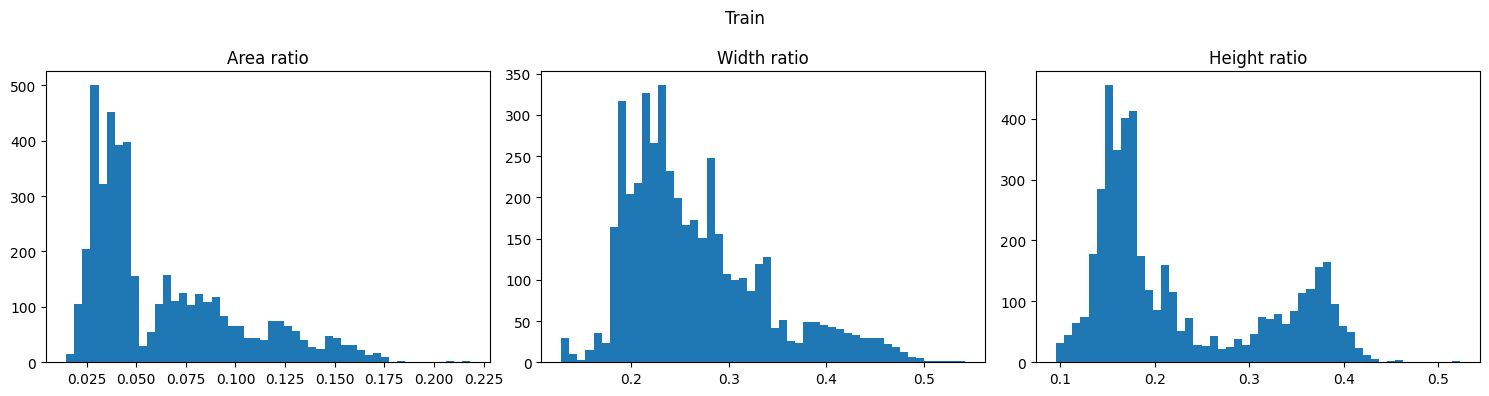


=== Validation ===
bbox 개수: 5512
area mean: 0.0610
area min/max: 0.0043 / 0.4132
width mean: 0.2571
width min/max: 0.0236 / 0.5400
height mean: 0.2246
height min/max: 0.0891 / 1.7766


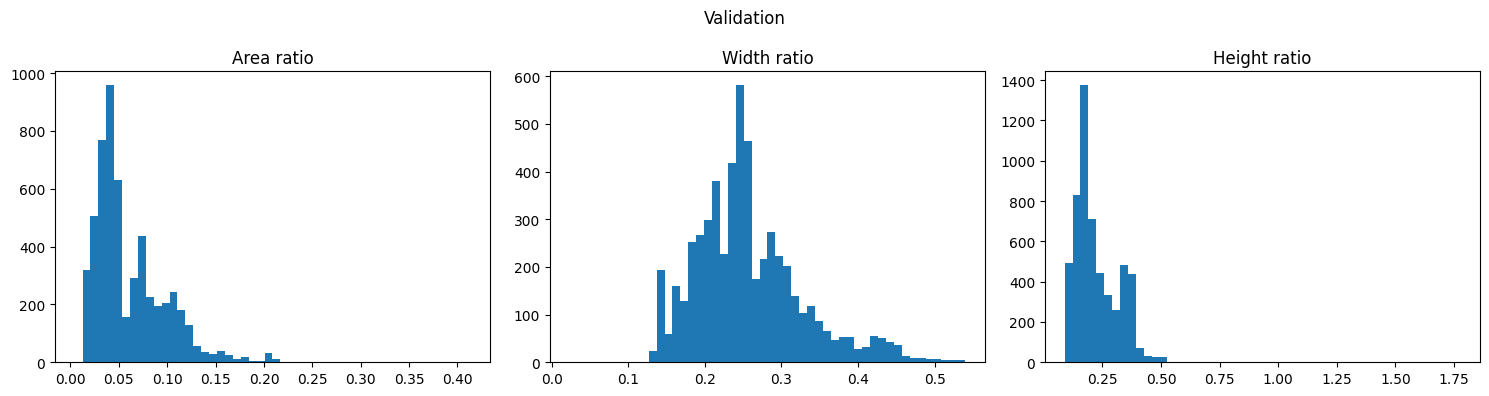

In [5]:
#4. bbox 크기 분포 확인
import numpy as np
import matplotlib.pyplot as plt

def bbox_size_distribution(json_paths, title="bbox distribution"):

    area_ratios = []
    w_ratios = []
    h_ratios = []

    for jp in json_paths:
        data = read_json(jp)

        img_map = {}
        for img in data.get("images", []):
            img_map[img["id"]] = (img["width"], img["height"])

        for ann in data.get("annotations", []):
            bbox = ann.get("bbox")
            if not bbox or len(bbox) != 4:
                continue

            img_id = ann.get("image_id")
            if img_id not in img_map:
                continue

            w_img, h_img = img_map[img_id]
            x, y, w, h = bbox

            if w <= 0 or h <= 0:
                continue

            area_ratios.append((w*h) / (w_img*h_img))
            w_ratios.append(w / w_img)
            h_ratios.append(h / h_img)

    area_ratios = np.array(area_ratios)
    w_ratios = np.array(w_ratios)
    h_ratios = np.array(h_ratios)

    print(f"\n=== {title} ===")
    print(f"bbox 개수: {len(area_ratios)}")
    print(f"area mean: {area_ratios.mean():.4f}")
    print(f"area min/max: {area_ratios.min():.4f} / {area_ratios.max():.4f}")
    print(f"width mean: {w_ratios.mean():.4f}")
    print(f"width min/max: {w_ratios.min():.4f} / {w_ratios.max():.4f}")
    print(f"height mean: {h_ratios.mean():.4f}")
    print(f"height min/max: {h_ratios.min():.4f} / {h_ratios.max():.4f}")

    # ===== subplot =====
    fig, axes = plt.subplots(1, 3, figsize=(15,4))

    axes[0].hist(area_ratios, bins=50)
    axes[0].set_title("Area ratio")

    axes[1].hist(w_ratios, bins=50)
    axes[1].set_title("Width ratio")

    axes[2].hist(h_ratios, bins=50)
    axes[2].set_title("Height ratio")

    fig.suptitle(title)
    plt.tight_layout()
    plt.show()

    return area_ratios, w_ratios, h_ratios

#위에서 이미지를 삭제했으므로, 다시 bbox 크기 분포 확인
train_json_paths = search_json_files(TRAIN_LABEL_DIR)
val_json_paths   = search_json_files(VAL_LABEL_DIR)

bbox_size_distribution(train_json_paths, "Train");
bbox_size_distribution(val_json_paths, "Validation");

In [6]:
#Height ration validation에서 0.9 이상인 박스 존재. 
#학습에 문제 될 수 있으므로  Height ratio 0.6 이상인 박스의 json+png 쌍 삭제
#log 저장
from datetime import datetime
import os

def delete_large_height_bbox_pairs(json_paths, raw_root_dir, thr=0.6, log_dir="logs"):

    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir,
        f"deleted_height_ratio_{thr}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    deleted_json = 0
    deleted_png = 0
    log_lines = []

    for jp in json_paths:
        data = read_json(jp)

        # image_id -> (w,h,file)
        img_map = {}
        for img in data.get("images", []):
            img_map[img["id"]] = (img["width"], img["height"], img["file_name"])

        delete_flag = False

        for ann in data.get("annotations", []):
            bbox = ann.get("bbox")
            if not bbox or len(bbox) != 4:
                continue

            img_id = ann.get("image_id")
            if img_id not in img_map:
                continue

            w_img, h_img, fname = img_map[img_id]
            _, _, _, h = bbox

            if h_img > 0 and (h / h_img) >= thr:
                delete_flag = True
                break

        if not delete_flag:
            continue

        # --- PNG 삭제 ---
        for _, _, fname in img_map.values():
            for root, _, files in os.walk(raw_root_dir):
                if fname in files:
                    png_path = os.path.join(root, fname)
                    os.remove(png_path)
                    log_lines.append(f"PNG DELETE: {png_path}")
                    deleted_png += 1
                    break

        # --- JSON 삭제 ---
        os.remove(jp)
        log_lines.append(f"JSON DELETE: {jp}")
        deleted_json += 1

    # 로그 저장
    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n")
        f.write(f"삭제 PNG: {deleted_png}\n\n")
        f.write("\n".join(log_lines))

    print(f"삭제 완료 → JSON:{deleted_json}, PNG:{deleted_png}")
    print(f"로그 저장 → {log_path}")

delete_large_height_bbox_pairs(train_json_paths, TRAIN_RAW_DIR, thr=0.5)
delete_large_height_bbox_pairs(val_json_paths, VAL_RAW_DIR, thr=0.5)


삭제 완료 → JSON:3, PNG:3
로그 저장 → logs\deleted_height_ratio_0.5_20260224_033113.txt
삭제 완료 → JSON:27, PNG:27
로그 저장 → logs\deleted_height_ratio_0.5_20260224_033113.txt


In [7]:
#5. bbox가 이미지 밖으로 나간 경우 삭제 및 로그저장
#조건 : x < 0 또는 y < 0 , x+w > image_width, y+h > image_height

#위에서 이미지를 삭제했으므로, 다시 bbox 크기 분포 확인
train_json_paths = search_json_files(TRAIN_LABEL_DIR)
val_json_paths   = search_json_files(VAL_LABEL_DIR)

from datetime import datetime
import os

def delete_outside_bbox_pairs(json_paths, raw_root_dir, log_dir="logs"):

    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir,
        f"deleted_outside_bbox_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    deleted_json = 0
    deleted_png = 0
    log_lines = []

    for jp in json_paths:
        data = read_json(jp)

        # image_id -> (w,h,file)
        img_map = {}
        for img in data.get("images", []):
            img_map[img["id"]] = (img["width"], img["height"], img["file_name"])

        delete_flag = False

        for ann in data.get("annotations", []):
            bbox = ann.get("bbox")
            if not bbox or len(bbox) != 4:
                continue

            img_id = ann.get("image_id")
            if img_id not in img_map:
                continue

            w_img, h_img, fname = img_map[img_id]
            x, y, w, h = bbox

            # ✅ bbox가 이미지 밖
            if x < 0 or y < 0 or (x + w) > w_img or (y + h) > h_img:
                delete_flag = True
                break

        if not delete_flag:
            continue

        # --- PNG 삭제 ---
        for _, _, fname in img_map.values():
            for root, _, files in os.walk(raw_root_dir):
                if fname in files:
                    png_path = os.path.join(root, fname)
                    os.remove(png_path)
                    log_lines.append(f"PNG DELETE: {png_path}")
                    deleted_png += 1
                    break

        # --- JSON 삭제 ---
        os.remove(jp)
        log_lines.append(f"JSON DELETE: {jp}")
        deleted_json += 1

    # 로그 저장
    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n")
        f.write(f"삭제 PNG: {deleted_png}\n\n")
        f.write("\n".join(log_lines))

    print(f"삭제 완료 → JSON:{deleted_json}, PNG:{deleted_png}")
    print(f"로그 저장 → {log_path}")

delete_outside_bbox_pairs(train_json_paths, TRAIN_RAW_DIR)
delete_outside_bbox_pairs(val_json_paths, VAL_RAW_DIR)

#

삭제 완료 → JSON:2, PNG:2
로그 저장 → logs\deleted_outside_bbox_20260224_033116.txt
삭제 완료 → JSON:2, PNG:2
로그 저장 → logs\deleted_outside_bbox_20260224_033116.txt


In [8]:
#6.annotation이 없는 이미지 존재 여부 및 삭제, 로그저장
#크기분포 재확인
train_json_paths = search_json_files(TRAIN_LABEL_DIR)
val_json_paths   = search_json_files(VAL_LABEL_DIR)

import os
from datetime import datetime

def delete_no_annotation_pairs(json_paths, raw_root_dir, log_dir="logs"):
    """
    - JSON에서 annotation이 없거나(annotations empty),
      bbox 길이 4인 유효 annotation이 0개면 'no-annotation'으로 간주
    - 해당 JSON 삭제
    - JSON의 images[].file_name에 해당하는 PNG만 삭제
    - 삭제 로그 저장
    """
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir,
        f"deleted_no_annotation_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    deleted_json = 0
    deleted_png = 0
    logs = []

    for jp in json_paths:
        data = read_json(jp)

        # 유효 annotation(bbox 4개) 개수
        valid_ann = 0
        for ann in data.get("annotations", []):
            bbox = ann.get("bbox")
            if bbox and len(bbox) == 4:
                valid_ann += 1

        if valid_ann > 0:
            continue  # 정상

        # --- PNG 삭제 (이 JSON이 가리키는 파일만) ---
        for img in data.get("images", []):
            fname = img.get("file_name")
            if not fname:
                continue

            found = False
            for root, _, files in os.walk(raw_root_dir):
                if fname in files:
                    png_path = os.path.join(root, fname)
                    os.remove(png_path)
                    logs.append(f"PNG DELETE: {png_path}")
                    deleted_png += 1
                    found = True
                    break
            if not found:
                logs.append(f"PNG MISSING (skip): {fname}")

        # --- JSON 삭제 ---
        os.remove(jp)
        logs.append(f"JSON DELETE: {jp} (valid_ann=0)")
        deleted_json += 1

    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n")
        f.write(f"삭제 PNG: {deleted_png}\n\n")
        f.write("\n".join(logs))

    print(f"삭제 완료 → JSON:{deleted_json}, PNG:{deleted_png}")
    print(f"로그 저장 → {log_path}")

delete_no_annotation_pairs(train_json_paths, TRAIN_RAW_DIR)
delete_no_annotation_pairs(val_json_paths, VAL_RAW_DIR)

삭제 완료 → JSON:0, PNG:0
로그 저장 → logs\deleted_no_annotation_20260224_033117.txt
삭제 완료 → JSON:0, PNG:0
로그 저장 → logs\deleted_no_annotation_20260224_033118.txt


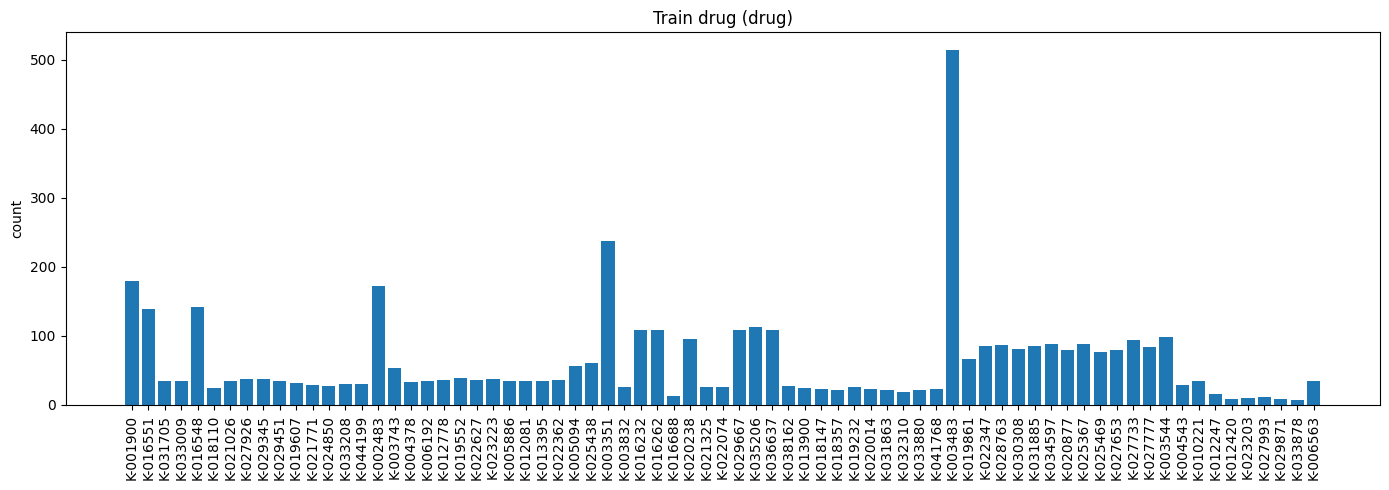

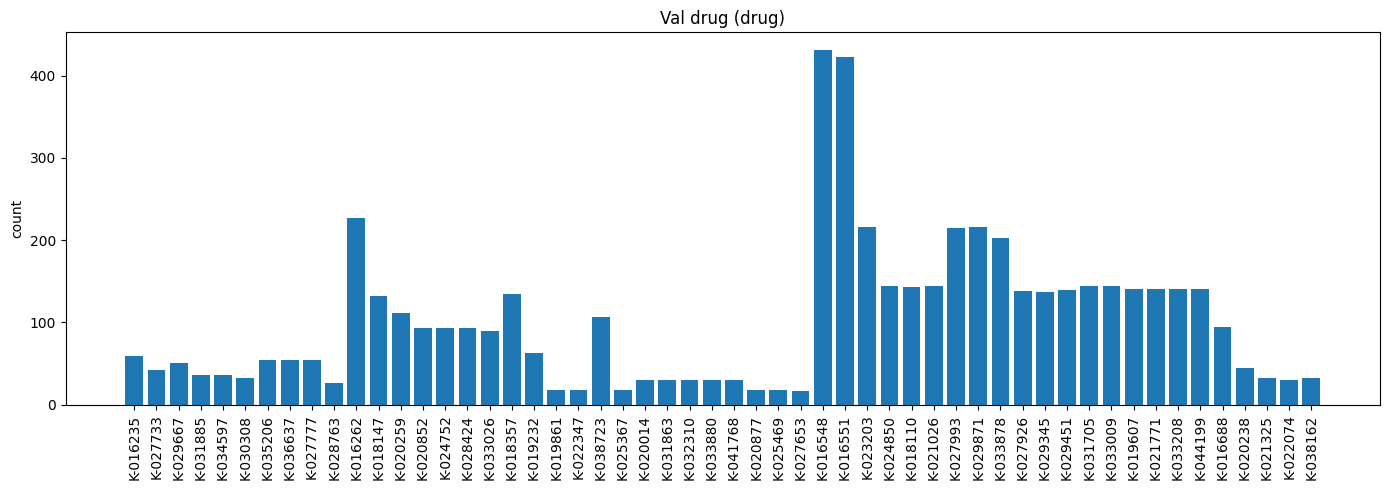

In [9]:
#7. 클래스 분포 확인
train_json_paths = search_json_files(TRAIN_LABEL_DIR)
val_json_paths   = search_json_files(VAL_LABEL_DIR)

import matplotlib.pyplot as plt
from collections import Counter

def class_distribution(
    json_paths,
    mode="drug",
    title="Class Distribution",
    verbose=False,
    show_labels=True,
):

    counter = Counter()

    for jp in json_paths:
        data = read_json(jp)

        if mode == "category":
            for ann in data.get("annotations", []):
                cid = ann.get("category_id")
                if cid is not None:
                    counter[cid] += 1

        elif mode == "drug":
            for img in data.get("images", []):
                drug = img.get("drug_N")
                if drug:
                    counter[drug] += 1

    # ---- 콘솔 출력 (옵션) ----
    if verbose:
        print(f"\n=== {title} ({mode}) ===")
        print(f"클래스 수: {len(counter)}")
        for k, v in counter.most_common():
            print(k, v)

    # ---- 그래프 ----
    labels = list(counter.keys())
    values = list(counter.values())

    plt.figure(figsize=(14,5))
    plt.bar(range(len(labels)), values)
    plt.title(f"{title} ({mode})")
    plt.ylabel("count")

    if show_labels:
        plt.xticks(range(len(labels)), labels, rotation=90)
    else:
        plt.xticks([])

    plt.tight_layout()
    plt.show()

    return counter

class_distribution(train_json_paths, mode="drug", title="Train drug");
class_distribution(val_json_paths, mode="drug", title="Val drug");

In [10]:
from collections import Counter

def get_drug_counter(json_paths):
    c = Counter()
    for jp in json_paths:
        data = read_json(jp)
        for img in data.get("images", []):
            drug = img.get("drug_N")
            if drug:
                c[drug] += 1
    return c

def compare_train_val_classes(train_json_paths, val_json_paths, print_counts=True):
    train_c = get_drug_counter(train_json_paths)
    val_c   = get_drug_counter(val_json_paths)

    train_set = set(train_c.keys())
    val_set   = set(val_c.keys())

    only_train = sorted(train_set - val_set)
    only_val   = sorted(val_set - train_set)
    common     = sorted(train_set & val_set)

    print(f"Train classes: {len(train_set)}")
    print(f"Val classes  : {len(val_set)}")
    print(f"Common       : {len(common)}")
    print(f"Only Train   : {len(only_train)}")
    print(f"Only Val     : {len(only_val)}")

    if only_train:
        print("\n[Only in Train]")
        print(*only_train, sep="\n")

    if only_val:
        print("\n[Only in Val]")
        print(*only_val, sep="\n")

    # imbalance 지표(Train 기준)
    if len(train_c) > 0:
        max_k, max_v = train_c.most_common(1)[0]
        min_v = min(train_c.values())
        print(f"\nTrain imbalance ratio (max/min): {max_v}/{min_v} = {max_v/min_v:.2f}  (max={max_k})")

    if print_counts:
        # 공통 클래스의 Train/Val 카운트 비교(상위 20개만)
        print("\n[Common class counts: Train vs Val] (top 20 by Train)")
        for k, v in train_c.most_common(20):
            if k in val_c:
                print(f"{k}: {v} / {val_c[k]}")

    return train_c, val_c, only_train, only_val

train_c, val_c, only_train, only_val = compare_train_val_classes(train_json_paths, val_json_paths)

Train classes: 73
Val classes  : 54
Common       : 47
Only Train   : 26
Only Val     : 7

[Only in Train]
K-001900
K-002483
K-003351
K-003483
K-003544
K-003743
K-003832
K-004378
K-004543
K-005094
K-005886
K-006192
K-006563
K-010221
K-012081
K-012247
K-012420
K-012778
K-013395
K-013900
K-016232
K-019552
K-022362
K-022627
K-023223
K-025438

[Only in Val]
K-016235
K-020259
K-020852
K-024752
K-028424
K-033026
K-038723

Train imbalance ratio (max/min): 514/7 = 73.43  (max=K-003483)

[Common class counts: Train vs Val] (top 20 by Train)
K-016548: 142 / 431
K-016551: 139 / 423
K-035206: 113 / 54
K-029667: 109 / 51
K-016262: 108 / 227
K-036637: 108 / 54
K-020238: 95 / 45
K-027733: 94 / 42
K-034597: 88 / 36
K-025367: 88 / 18
K-028763: 87 / 27
K-022347: 85 / 18
K-031885: 85 / 36
K-027777: 84 / 54


#심각한 문제 인식.
- Train 데이터와 Val 데이터 상 서로 존재하지 않은 항목들이 존재했고 또한 사전에 Test Data를 구성하지 않았다. 

- 새로운 데이터 셋을 가져오기에는 기존의 데이터 셋 용량도 충분히 크고 EDA 과정이 지체되었다.

- 따라서 이 시점에서 Val 데이터 셋 중 Train Data에 존재하지 않는 항목들은 삭제하고 Val 데이터 셋을 Test로 사용하기로 하였다.

In [13]:
# 8. Val Set에만 존재하는 클래스 삭제 및 로그 저장
from datetime import datetime
import os

def delete_val_not_in_train(train_json_paths, val_json_paths, val_raw_dir, log_dir="logs"):

    # ---- Train drug set ----
    train_drugs = set()
    for jp in train_json_paths:
        data = read_json(jp)
        for img in data.get("images", []):
            d = img.get("drug_N")
            if d:
                train_drugs.add(d)

    # ---- 로그 준비 ----
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir,
        f"deleted_val_not_in_train_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    deleted_json = 0
    deleted_png = 0
    logs = []

    # ---- Validation 검사 ----
    for jp in val_json_paths:
        data = read_json(jp)

        delete_flag = False
        drug_name = None

        for img in data.get("images", []):
            drug_name = img.get("drug_N")
            if drug_name and drug_name not in train_drugs:
                delete_flag = True
                break

        if not delete_flag:
            continue

        # --- PNG 삭제 ---
        for img in data.get("images", []):
            fname = img.get("file_name")
            if not fname:
                continue

            for root, _, files in os.walk(val_raw_dir):
                if fname in files:
                    png_path = os.path.join(root, fname)
                    os.remove(png_path)
                    logs.append(f"PNG DELETE: {png_path}")
                    deleted_png += 1
                    break

        # --- JSON 삭제 ---
        os.remove(jp)
        logs.append(f"JSON DELETE: {jp} (drug_N={drug_name} not in train)")
        deleted_json += 1

    # ---- 로그 저장 ----
    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n")
        f.write(f"삭제 PNG: {deleted_png}\n\n")
        f.write("\n".join(logs))

    print(f"삭제 완료 → JSON:{deleted_json}, PNG:{deleted_png}")
    print(f"로그 저장 → {log_path}")


delete_val_not_in_train(train_json_paths, val_json_paths, VAL_RAW_DIR)

삭제 완료 → JSON:646, PNG:620
로그 저장 → logs\deleted_val_not_in_train_20260224_033427.txt


In [14]:
#JSON이 있는데 PNG가 없는 JSON 삭제 -> 학습은 JSON을 기준으로 진행할 것
from datetime import datetime

def delete_missing_png_pairs(json_paths, raw_root_dir, log_dir="logs"):
    """
    json은 있는데 raw_root_dir 아래에 해당 png(file_name)가 없는 경우:
    - 해당 json 삭제
    - 삭제 로그 저장
    """
    os.makedirs(log_dir, exist_ok=True)
    log_path = os.path.join(
        log_dir, f"deleted_missing_png_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
    )

    deleted_json = 0
    logs = []

    for jp in json_paths:
        data = read_json(jp)

        # json 안의 images 중 하나라도 png가 없으면 이 json은 삭제 대상으로 처리
        missing_any = False
        missing_names = []

        for img in data.get("images", []):
            fname = img.get("file_name")
            if not fname:
                continue

            found = False
            for root, _, files in os.walk(raw_root_dir):
                if fname in files:
                    found = True
                    break

            if not found:
                missing_any = True
                missing_names.append(fname)

        if not missing_any:
            continue

        os.remove(jp)
        deleted_json += 1
        logs.append(f"JSON DELETE: {jp} | missing_png={missing_names}")

    with open(log_path, "w", encoding="utf-8") as f:
        f.write(f"삭제 JSON: {deleted_json}\n\n")
        f.write("\n".join(logs))

    print(f"삭제 완료 → JSON:{deleted_json}")
    print(f"로그 저장 → {log_path}")



In [16]:
# =========================
# 1) 재확인
count_json_files(train_json_paths, "Train")
count_json_files(val_json_paths, "Validation")

train_json_paths = search_json_files(TRAIN_LABEL_DIR)
val_json_paths   = search_json_files(VAL_LABEL_DIR)

missing_train = check_json_png_match(train_json_paths, TRAIN_RAW_DIR)
missing_val   = check_json_png_match(val_json_paths, VAL_RAW_DIR)

# 2) 미스매칭 pair 삭제 (png가 없는 json 삭제)
delete_missing_png_pairs(train_json_paths, TRAIN_RAW_DIR)
delete_missing_png_pairs(val_json_paths, VAL_RAW_DIR)

# 3) 삭제 후 재스캔(권장)
train_json_paths = search_json_files(TRAIN_LABEL_DIR)
val_json_paths   = search_json_files(VAL_LABEL_DIR)

missing_train = check_json_png_match(train_json_paths, TRAIN_RAW_DIR)
missing_val   = check_json_png_match(val_json_paths, VAL_RAW_DIR)

Train JSON 개수: 4507
Validation JSON 개수: 5483
missing png: K-003351-016262-018357_0_2_0_2_75_000_200.png
missing png: K-003351-016262-018357_0_2_0_2_75_000_200.png
missing png: K-003351-016688-019232_0_2_0_2_90_000_200.png
missing png: K-003351-016688-019232_0_2_0_2_75_000_200.png
missing png: K-003351-016688-019232_0_2_0_2_90_000_200.png
missing png: K-003351-016688-041768_0_2_0_2_90_000_200.png
missing png: K-003351-016688-041768_0_2_0_2_90_000_200.png
missing png: K-003544-004543-012247-016551_0_2_0_2_70_000_200.png

총 이미지 entries: 4507
png 누락: 8
missing png: K-016235-027733-029667-031885_0_2_0_2_70_000_200.png
missing png: K-016235-027733-029667-031885_0_2_0_2_75_000_200.png
missing png: K-016235-027733-029667-031885_0_2_0_2_90_000_200.png
missing png: K-016235-027733-029667-031885_0_2_0_2_70_000_200.png
missing png: K-016235-027733-029667-031885_0_2_0_2_75_000_200.png
missing png: K-016235-027733-029667-031885_0_2_0_2_90_000_200.png
missing png: K-016235-027733-029667-031885_0_2_0_